# Multi-head and Multilayer

In [1]:
import numpy as np
import pickle
import time
from matplotlib import pyplot as plt
import gc
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from lstm_data_prep import numpy_prep
from eval_model import epoch_time, find_lens, accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class Transformer(nn.Module):
    def __init__(self, n_input, n_output, seq_len, n_head, dim_ff, num_layers, position_encoding):
        super().__init__()

        self.n_input = n_input
        self.n_output = n_output
        self.n_head = n_head
        self.dim_ff = dim_ff
        self.num_layers = num_layers
        self.position_encoding = position_encoding
        self.seq_len = seq_len

        self.transformerlayer = nn.TransformerEncoderLayer(n_input, n_head, dim_feedforward=dim_ff, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformerlayer, num_layers)
        self.fc = nn.Linear(n_input, n_output)

    def position_encode(self):
        pe = torch.zeros(self.seq_len, self.n_input).to(device)
        pos = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.n_input, 2).float() * (-np.log(10000.0) / self.n_input))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        return pe
    
    def forward(self, X):
        x = X.to(device)
        if self.position_encoding:
            pe = self.position_encode()
            pe = pe.expand(X.size(0), -1, -1)
            x = X + pe
        y = self.transformer_encoder(x)
        y = self.fc(y)
        return y
    

In [3]:
class TransformerModel:
    def __init__(self, model, loss_fn, optimizer, seq_len, model_name):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.seq_len = seq_len
        self.model_name = model_name
        
        total_params = sum(p.numel() for p in self.model.parameters())
        print(total_params)

    def train(self, train_loader, n_epochs=10, learning=1e-2):
        train_loss = []
        best_loss = 1e10

        self.model.train()
        for i in range(n_epochs):
            start = time.time()
            avg_loss = 0.
            for X, y in train_loader:
                loss = 0.
                curr_batch_size = X.shape[0]

                X, y = X.to(device), y.to(device)
                self.optimizer.zero_grad()

                output = self.model(X)

                out = output.permute(0, 2, 1)
                target = y.permute(0, 2, 1)

                loss += self.loss_fn(out, target)
                
                loss.backward()
                self.optimizer.step()
                avg_loss += loss.item()

            end = time.time()
            epoch_mins, epoch_secs = epoch_time(start, end)
            if best_loss > avg_loss:
                best_loss = avg_loss
                torch.save({self.model_name: self.model.state_dict(), self.model_name+"_optimizer": self.optimizer.state_dict()}, self.model_name+'-model.pt')

            print("Epoch " + str(i + 1) + "/" + str(n_epochs))
            print("Time: " + str(epoch_mins) + " minutes " + str(epoch_secs) + " seconds")
            print("Training loss: " + str(avg_loss))
            print()
            train_loss.append(avg_loss)
        return train_loss
    
    def eval(self, test_loader):
        check = torch.load(self.model_name+"-model.pt")
        self.model.load_state_dict(check[self.model_name])

        gc.collect()
        torch.cuda.empty_cache()

        with torch.no_grad():
            correct = np.zeros(self.seq_len)
            total = np.zeros(self.seq_len)
            self.model.eval()

            for x, y in test_loader:
                loss = 0.
                curr_batch_size = x.shape[0]
                X, Y = x.to(device), y.to(device)

                out = self.model(X)

                top_value, top_index = out.topk(1)

                final = torch.zeros(y.shape).to(device)
                for clip in range(y.shape[0]):
                    for step in range(y.shape[1]):
                        final[clip][step][top_index[clip][step]] = 1
                
                correct, total = accuracy(y.cpu().numpy(), final.cpu().numpy(), correct, total)
        
        ff_accuracy = correct / total
        return ff_accuracy, loss
    
    def random_samples(self, X, pad=0.):
        X_random = []
        X_lens = find_lens(X)
        for i in range(X.shape[0]):
            X_batch = np.random.normal(size=(X_lens[i], X.shape[-1]))
            if X_lens[i] < self.seq_len:
                X_pad = np.array([[pad]*X.shape[-1]]*(self.seq_len - X_lens[i]))
                X_batch = np.append(X_batch, X_pad, axis=0)
            X_random.append(X_batch)
        X_random = np.array(X_random)
        return X_random
    
    def rand_test(self, test_loader, n_samples=1, percentile=100):
        rand_acc_array = []
        for sample in range(n_samples):
            correct = np.zeros(self.seq_len)
            total = np.zeros(self.seq_len)
            
            self.model.eval()

            for x, y in test_loader:
                loss = 0.
                curr_batch_size = x.shape[0]
                X_random = torch.from_numpy(self.random_samples(x)).float().to(device)
                Y = y.to(device)

                out = self.model(X_random)

                top_value, top_index = out.topk(1)
                final = torch.zeros(y.shape).to(device)
                for clip in range(y.shape[0]):
                    for step in range(y.shape[1]):
                        final[clip][step][top_index[clip][step]] = 1
                
                correct, total = accuracy(y.cpu().numpy(), final.cpu().numpy(), correct, total)
            gru_rand_acc = correct / total
            rand_acc_array.append(gru_rand_acc)
        plot = np.percentile(np.sort(np.array(rand_acc_array), axis=0), percentile, axis=0)
        return plot

In [4]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

X_train, y_train, X_t, y_t = numpy_prep(TS, pad = 0.)

batch_size = 32

train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(X_t).float(), torch.from_numpy(y_t).float())
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

c:\Users\annax\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [8]:
n_input = 300
dim_ff = 32
n_out = 15
seq_len = 90
learning_rate = 1e-3
EPOCHS = 50
num_head = 4
num_layers = 1
position_encoding = False

transformer_encoder_multi = Transformer(n_input, n_out, seq_len, num_head, dim_ff, num_layers, position_encoding).to(device)
loss_fn_multi = nn.CrossEntropyLoss()
optimizer_multi = optim.Adam(transformer_encoder_multi.parameters(), lr=learning_rate)

model_multi = TransformerModel(transformer_encoder_multi, loss_fn_multi, optimizer_multi , seq_len, "transformer_multi")

768379


In [ ]:
train_loss = model_multi.train(train_loader, n_epochs=EPOCHS)
xAx = [i for i in range(1, EPOCHS+1)]
plt.plot(xAx, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlim(1, EPOCHS)
plt.xticks([j for j in range(1, EPOCHS+1)])
plt.title("Training Loss")
plt.show()

In [39]:
transformer_multi_acc, loss = model_multi.eval(test_loader)
%store transformer_multi_acc
np.save('transformer_multi_acc.npy', transformer_multi_acc)

Stored 'transformer_multi_acc' (ndarray)


In [37]:
transformer_multi_rand_acc = model_multi.rand_test(test_loader)
%store transformer_multi_rand_acc

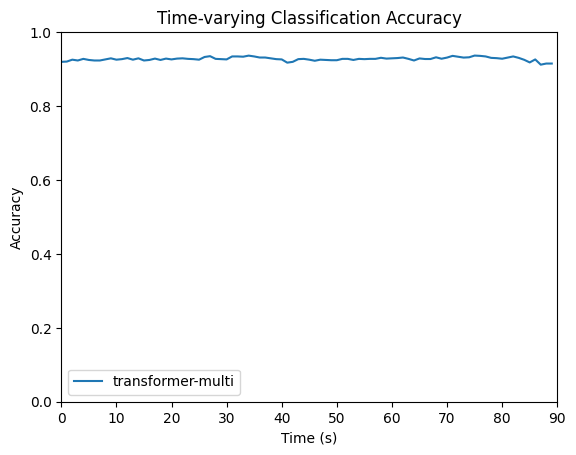

In [40]:
xAx = [i for i in range(0,90)]
plt.plot(xAx, transformer_multi_accuracy, label="transformer-multi")
# plt.plot(xAx, transformer_multi_rand_acc, label="random")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()